In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, Bounds, LinearConstraint
print("Imports Successful!")

Imports Successful!


In [2]:
def fetch_and_prepare_data():
    tickers = {
        "Gold" : "GC=F",
        "Silver" : "SI=F",
        "Copper" : "HG=F",
        "EURUSD" : "EURUSD=X", 
        "USDCHF" : "USDCHF=X",
        "Bitcoin" : "BTC-USD",
        "NVIDIA" :  "NVDA",
        "Palantir" : "PLTR",
        "Oracle" : "ORCL",
        "Walmart" : "WMT"
    }
    
    start_date = "2023-01-01"
    end_date = "2025-07-01"
    
    portfolio_data = {}
    for name,ticker in tickers.items():
        data = yf.download(ticker, start = start_date, end = end_date)['Close']
        portfolio_data[name] = data.rename(columns=lambda col: f"{name}_{col}")
        
    data = pd.concat(portfolio_data.values(), axis=1)
    data = data.ffill()
    
    df = data.pct_change().dropna()
    r = np.mean(df, axis=0) * 252
    covar = df.cov() * 252
    
    return data, df, r, covar

In [3]:
def plot_raw_prices(df):
    plt.figure(figsize=(15,6))
    for i in range(df.shape[1]):
        plt.plot(df.iloc[:,i], label=df.columns[i])
    plt.legend(loc="upper left", fontsize=12)
    plt.ylabel("Price in $")
    plt.title("Raw Prices of Assets")
    plt.show()

In [4]:
def plot_normalized_prices(df):
    df_normalized = df.copy()
    for col in df.columns:
        first_valid = df[col].first_valid_index()
        df_normalized[col] = (df[col] / df.loc[first_valid, col] - 1) * 100

    plt.figure(figsize=(15,6))
    for col in df_normalized.columns:
        plt.plot(df_normalized.index, df_normalized[col], label=col)
    plt.legend(loc="upper left", fontsize=12)
    plt.ylabel("Cumulative % Change (Start = 0%)")
    plt.title("Normalized Price Comparison")
    plt.show()

In [5]:
def portfolio_return(weights, r):
    return np.dot(weights, r)

def portfolio_volatility(weights, covar):
    return np.sqrt(np.dot(weights, np.dot(covar, weights)))

def sharpe_ratio(weights, r, covar, risk_free=0.02):
    ret = portfolio_return(weights, r)
    vol = portfolio_volatility(weights, covar)
    return (ret - risk_free) / vol

In [6]:
def setup_optimization(r):
    n = len(r)
    bounds = Bounds(0,1)
    linear_constraint = LinearConstraint(np.ones(n),1,1)
    x0 = np.ones(n) / n
    return n, bounds, linear_constraint, x0

In [7]:
def min_vol_portfolio(r, covar, x0, linear_constraint, bounds):
    fun_vol = lambda w: portfolio_volatility(w, covar)
    res = minimize(fun_vol, x0, method='trust-constr',
                   constraints=linear_constraint, bounds=bounds)
    w = res.x
    return w, portfolio_return(w,r), portfolio_volatility(w,covar)

def max_sharpe_portfolio(r, covar, x0, linear_constraint, bounds, method='trust-constr'):
    fun_sharpe = lambda w: - sharpe_ratio(w, r, covar, risk_free=0.02)
    if method == "trust-constr":
        res = minimize(fun_sharpe, x0, method='trust-constr',
                       constraints=linear_constraint, bounds=bounds)
    else:
        res = minimize(fun_sharpe, x0, method='SLSQP',
                       constraints={'type':'eq', 'fun': lambda w: np.sum(w)-1},
                       bounds=[(0, 1) for _ in range(len(r))])
    
    w = res.x
    return w, portfolio_return(w, r), portfolio_volatility(w, covar)

In [8]:
def efficient_frontier(r, covar, x0, bounds, linear_constraint, ret_min, num_ports=100):
    fun_vol = lambda w: portfolio_volatility(w, covar)
    ret_arr, vol_arr = [],[]
    for target_return in np.linspace(ret_min, max(r), num_ports):
        double_constraint = [linear_constraint, LinearConstraint(r, target_return, target_return)]
        res = minimize(fun_vol, x0, method='trust-constr',
                       constraints=double_constraint, bounds=bounds)
        ret_arr.append(target_return)
        vol_arr.append(portfolio_volatility(res.x, covar))
    return ret_arr, vol_arr

In [9]:
def monte_carlo_simulation(r, covar, mc_ports= 50000):
    n = len(r)
    mc_returns, mc_vols, mc_sharpes = [], [], []
    for i in range(mc_ports):
        w = np.random.random(n)
        w /=np.sum(w)
        mc_returns.append(portfolio_return(w, r))
        mc_vols.append(portfolio_volatility(w, covar))
        mc_sharpes.append(sharpe_ratio(w, r, covar))
    return mc_returns, mc_vols, mc_sharpes

In [10]:
def plot_results(mc_vols, mc_returns, mc_sharpes, vol_arr, ret_arr,
                 vol_min, ret_min, vol_sharpe, ret_sharpe, vol_sharpe_slsqp, ret_sharpe_slsqp):
    plt.figure(figsize=(14,8))
    plt.scatter(mc_vols, mc_returns, c=mc_sharpes, cmap='viridis', alpha=.2, label='Monte Carlo')
    plt.plot(vol_arr, ret_arr, 'r--', linewidth=3, label="efficient_frontier (trust-constr)")
    plt.scatter(vol_min, ret_min, c='blue', s=150, marker='*', label="Minimum Volatility Portfolio")
    plt.scatter(vol_sharpe, ret_sharpe, c='red', s=150, marker='*', label="Max Sharpe (trust-constr)")
    plt.scatter(vol_sharpe_slsqp, ret_sharpe_slsqp, c='green', s=150, marker='*', label="Max Sharpe (SLSQP)")
    plt.xlabel("Volatility")
    plt.ylabel("Return")
    plt.colorbar(label="Sharpe Ratio (Monte Carlo)")
    plt.legend()
    plt.show()

In [ ]:
portfolio_data, df, r ,covar = fetch_and_prepare_data()

/var/folders/fx/rwrqnvd16p3dzcfy6khs1ts40000gn/T/ipykernel_68393/1267739056.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start = start_date, end = end_date)['Close']
[*********************100%***********************]  1 of 1 completed
/var/folders/fx/rwrqnvd16p3dzcfy6khs1ts40000gn/T/ipykernel_68393/1267739056.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start = start_date, end = end_date)['Close']
[*********************100%***********************]  1 of 1 completed
/var/folders/fx/rwrqnvd16p3dzcfy6khs1ts40000gn/T/ipykernel_68393/1267739056.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start = start_date, end = end_date)['Close']
[*********************100%***********************]  1 of 1 completed
/var/folders/fx/rwrqnvd16p3dzcfy6khs1ts40000gn/T/ipykernel_68393/1267739056.py:20: Futur

In [12]:
df.head()

Ticker,Gold_GC=F,Silver_SI=F,Copper_HG=F,EURUSD_EURUSD=X,USDCHF_USDCHF=X,Bitcoin_BTC-USD,NVIDIA_NVDA,Palantir_PLTR,Oracle_ORCL,Walmart_WMT
Date,,,,,,,,,,
2023-01-04,0.007121,-0.011098,-0.007037,-0.012255,0.012771,0.010994,0.030318,0.029734,0.009078,0.001114
2023-01-05,-0.009715,-0.022445,0.020992,0.005642,-0.006636,-0.001572,-0.032816,-0.039514,-0.002012,-0.003408
2023-01-06,0.016023,0.024250,0.023703,-0.007934,0.006713,0.006844,0.041640,0.012658,0.016012,0.024499
2023-01-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000183,0.000000,0.000000,0.000000,0.000000
2023-01-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.008025,0.000000,0.000000,0.000000,0.000000


In [13]:
portfolio_data.head()

Ticker,Gold_GC=F,Silver_SI=F,Copper_HG=F,EURUSD_EURUSD=X,USDCHF_USDCHF=X,Bitcoin_BTC-USD,NVIDIA_NVDA,Palantir_PLTR,Oracle_ORCL,Walmart_WMT
Date,,,,,,,,,,
2023-01-01,NaN,NaN,NaN,NaN,NaN,16625.080078,NaN,NaN,NaN,NaN
2023-01-02,NaN,NaN,NaN,1.070973,0.92380,16688.470703,NaN,NaN,NaN,NaN
2023-01-03,1839.699951,24.059000,3.7660,1.067771,0.92400,16679.857422,14.301480,6.39,80.808517,46.241459
2023-01-04,1852.800049,23.792000,3.7395,1.054685,0.93580,16863.238281,14.735072,6.58,81.542084,46.292976
2023-01-05,1834.800049,23.257999,3.8180,1.060637,0.92959,16836.736328,14.251527,6.32,81.377998,46.135197


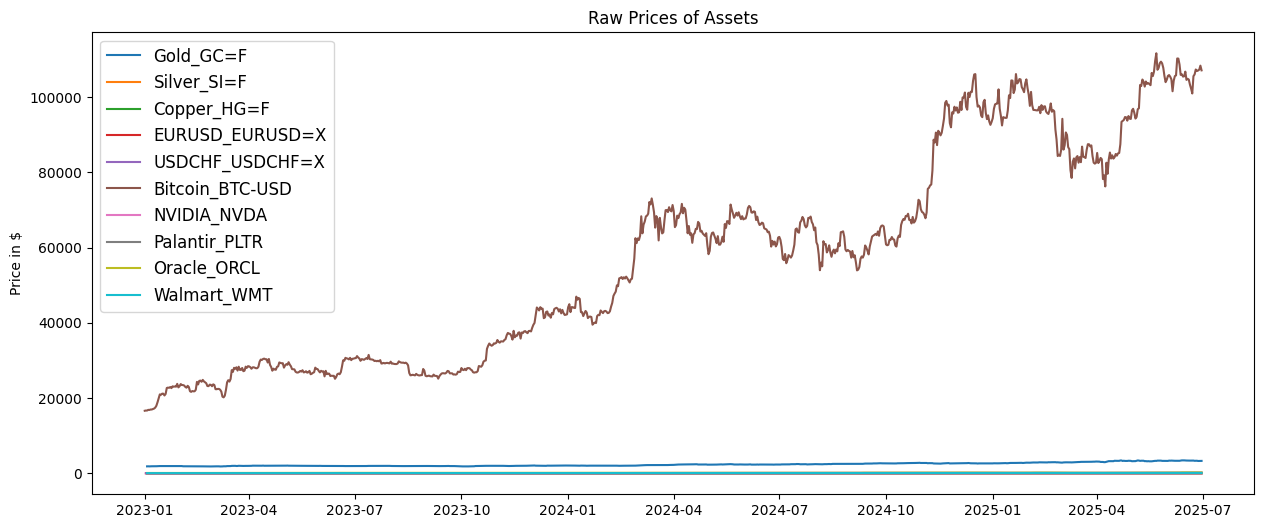

In [14]:
plot_raw_prices(portfolio_data)

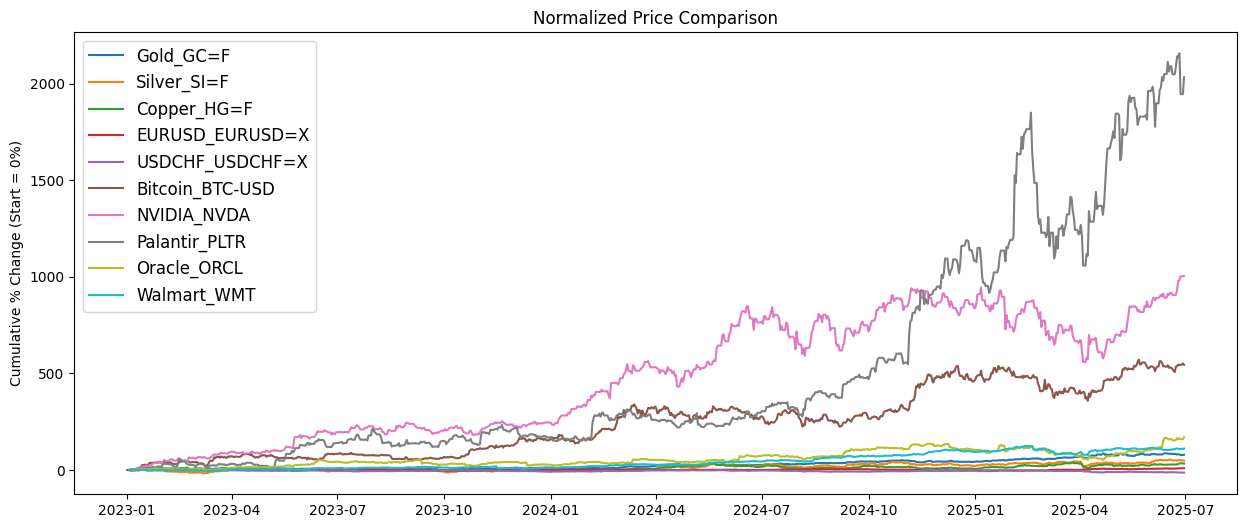

In [15]:
plot_normalized_prices(portfolio_data)

In [ ]:
n, bounds, linear_constraint, x0 = setup_optimization(r)

In [17]:
w_min, ret_min, vol_min = min_vol_portfolio(r, covar, x0, linear_constraint, bounds)

In [18]:
w_sharpe, ret_sharpe, vol_sharpe = max_sharpe_portfolio(r, covar, x0, linear_constraint, bounds, method='trust-constr')


In [19]:
w_sharpe_slsqp, ret_sharpe_slsqp, vol_sharpe_slsqp =max_sharpe_portfolio(r, covar, x0, linear_constraint, bounds, method='SLSQP')

In [20]:
ret_arr, vol_arr = efficient_frontier(r, covar, x0, bounds, linear_constraint, ret_min)

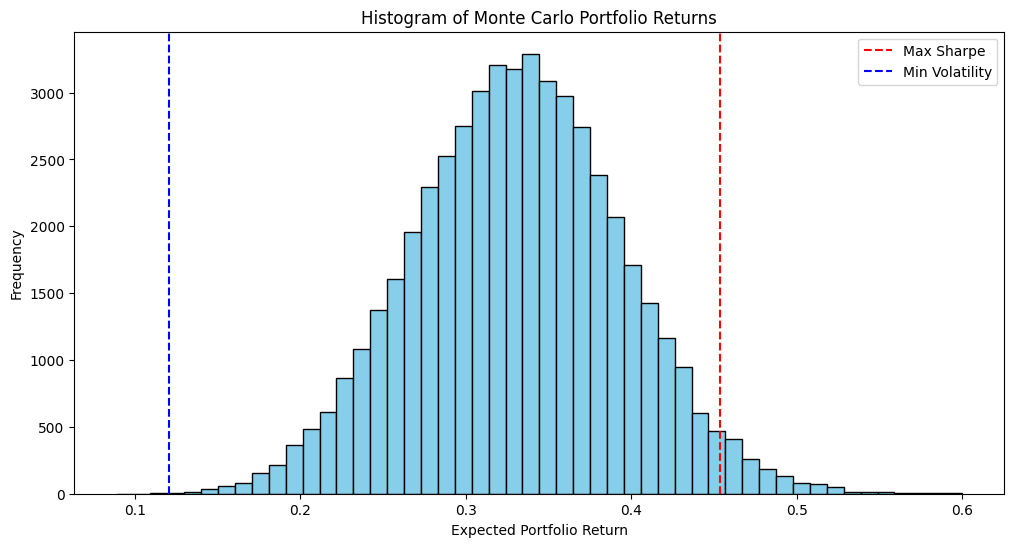

In [21]:
mc_returns, mc_vols, mc_sharpes = monte_carlo_simulation(r,covar)

plt.figure(figsize=(12,6))
plt.hist(mc_returns, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Expected Portfolio Return')
plt.ylabel('Frequency')
plt.title('Histogram of Monte Carlo Portfolio Returns')
max_sharpe_idx = np.array(mc_sharpes).argmax()
min_vol_idx = np.array(mc_vols).argmin()

plt.axvline(mc_returns[max_sharpe_idx], color='red', linestyle='--', label='Max Sharpe')
plt.axvline(mc_returns[min_vol_idx], color='blue', linestyle='--', label='Min Volatility')
plt.legend()
plt.show()


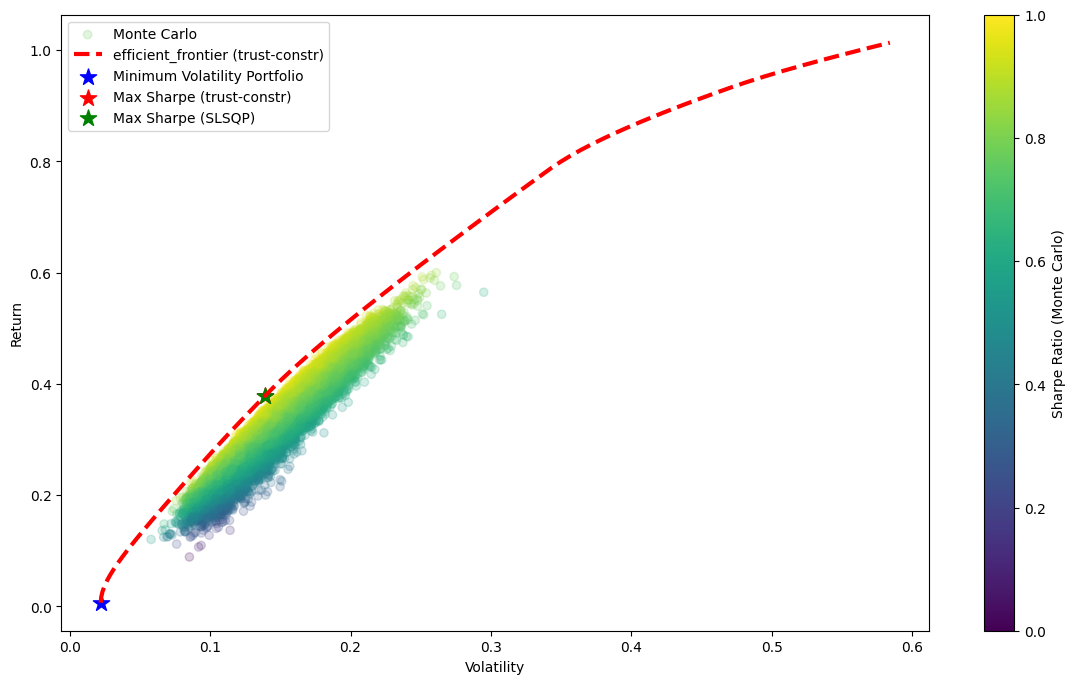

In [22]:
plot_results(mc_vols, mc_returns, mc_sharpes, vol_arr, ret_arr,
             vol_min, ret_min, vol_sharpe, ret_sharpe, vol_sharpe_slsqp, ret_sharpe_slsqp)

In [26]:
print("Minimum Volatility Portfolio:")
print(pd.Series(np.round(w_min,3), index= r.index))
print("Return: ", round(ret_min,4),"Volatility: ", round(vol_min,4))

Minimum Volatility Portfolio:
Ticker
Gold_GC=F          0.026
Silver_SI=F        0.000
Copper_HG=F        0.000
EURUSD_EURUSD=X    0.506
USDCHF_USDCHF=X    0.451
Bitcoin_BTC-USD    0.000
NVIDIA_NVDA        0.003
Palantir_PLTR      0.000
Oracle_ORCL        0.000
Walmart_WMT        0.013
dtype: float64
Return:  0.0067 Volatility:  0.0221


In [24]:
print("Maximum Sharpe (trust-constr):")
print(pd.Series(np.round(w_sharpe,3), index=r.index))
print("Return:", round(ret_sharpe,4), "Volatility:",round(vol_sharpe,4))

Maximum Sharpe (trust-constr):
Ticker
Gold_GC=F          0.425
Silver_SI=F        0.000
Copper_HG=F        0.000
EURUSD_EURUSD=X    0.011
USDCHF_USDCHF=X    0.000
Bitcoin_BTC-USD    0.114
NVIDIA_NVDA        0.134
Palantir_PLTR      0.083
Oracle_ORCL        0.000
Walmart_WMT        0.233
dtype: float64
Return: 0.3783 Volatility: 0.139


In [25]:
print("Maximum Sharpe (SLSQP):")
print(pd.Series(np.round(w_sharpe_slsqp,3), index=r.index))
print("Return:", round(ret_sharpe_slsqp,4), "Volatility:",round(vol_sharpe_slsqp,4))

Maximum Sharpe (SLSQP):
Ticker
Gold_GC=F          0.425
Silver_SI=F        0.000
Copper_HG=F        0.000
EURUSD_EURUSD=X    0.012
USDCHF_USDCHF=X    0.000
Bitcoin_BTC-USD    0.114
NVIDIA_NVDA        0.134
Palantir_PLTR      0.083
Oracle_ORCL        0.000
Walmart_WMT        0.232
dtype: float64
Return: 0.378 Volatility: 0.1389
